In [1]:
from utils import *

#Task 1

##Part 2
The chosen model is ConvNet

In [2]:
from ptflops import get_model_complexity_info
import matplotlib.pyplot as plt
from tqdm import tqdm


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Args:
    def __init__(self):
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'

def train(net, trainloader, criterion, optimizer,device=device):
    net.train()
    net.to(device)
    #create args.device 
    args = Args()
    args.device = device
    progress_bar = tqdm(range(20), total=20, desc=f'Training - No data available', leave=True)

    for i in progress_bar:
        loss_avg, acc_avg, num_exp = 0, 0, 0
        for i_batch, datum in enumerate(trainloader):
            img = datum[0].float().to(args.device)
            lab = datum[1].long().to(args.device)
            n_b = lab.shape[0]

            output = net(img)
            loss = criterion(output, lab)
            acc = np.sum(np.equal(np.argmax(output.cpu().data.numpy(), axis=-1), lab.cpu().data.numpy()))
            loss_avg += loss.item()*n_b
            acc_avg += acc
            num_exp += n_b

            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_avg /= num_exp
        acc_avg /= num_exp
        progress_bar.set_description(f'Training - Loss: {loss_avg:.4f} - Accuracy: {acc_avg:.4f}')
    return net

def test(net, testloader, criterion, optimizer,device=device):
    net.eval()
    net.to(device)
    args = Args()
    args.device = device
    loss_avg, acc_avg, num_exp = 0, 0, 0
    for i_batch, datum in enumerate(testloader):
        img = datum[0].float().to(args.device)
        lab = datum[1].long().to(args.device)
        n_b = lab.shape[0]

        output = net(img)
        loss = criterion(output, lab)
        acc = np.sum(np.equal(np.argmax(output.cpu().data.numpy(), axis=-1), lab.cpu().data.numpy()))
        loss_avg += loss.item()*n_b
        acc_avg += acc
        num_exp += n_b


    loss_avg /= num_exp
    acc_avg /= num_exp
    print(f'Accuracy of the network on the test images: {acc_avg*100}%')

def count_flops(net, channel, im_size):
    param = (channel, im_size[0], im_size[1])
    flops, params = get_model_complexity_info(net, param, as_strings=True, print_per_layer_stat=False)
    print(f'FLOPs: {flops}')
    print(f'Params: {params}')

In [3]:
#MNIST Dataset
data_path = "./Project A/data"

#load the dataset
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset("MNIST", data_path)

#define the model
net = get_network('ConvNetD3', channel, num_classes, im_size)
net.to(device)

#define the loss function
criterion = nn.CrossEntropyLoss()
#define the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
#define the learning rate scheduler
#train the model
#create trainloader
trainloader = torch.utils.data.DataLoader(dst_train, batch_size=64, shuffle=True)
net = train(net, trainloader, criterion, optimizer)

Training - No data available:   0%|          | 0/20 [00:00<?, ?it/s]

Training - Loss: 0.0122 - Accuracy: 0.9972: 100%|██████████| 20/20 [02:56<00:00,  8.83s/it]


In [4]:
#test the model, report accuracy and FLOPs
#testloader = torch.utils.data.DataLoader(dst_test, batch_size=64, shuffle=False)
test(net, testloader, criterion, optimizer, device)
#report the FLOPs
count_flops(net, channel, im_size) 

Accuracy of the network on the test images: 99.33%
FLOPs: 49.59 MMac
Params: 317.71 k


In [5]:
#MHIST Dataset
#load the dataset
data_path = "mhist_dataset"
#print files in the directory
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset("MHIST", data_path)

#define the model
net = get_network('ConvNetD7', channel, num_classes, im_size)
net.to(device) 

#define the loss function
criterion = nn.CrossEntropyLoss()
#define the optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
#define the learning rate scheduler
#train the model
#create trainloader
trainloader = torch.utils.data.DataLoader(dst_train, batch_size=64, shuffle=True)
net=train(net, trainloader, criterion, optimizer)
            
            

Training - No data available:   0%|          | 0/20 [00:00<?, ?it/s]

Training - Loss: 0.0760 - Accuracy: 0.9940: 100%|██████████| 20/20 [01:32<00:00,  4.63s/it]


In [6]:
#test the model, report accuracy and FLOPs
test(net, testloader, criterion, optimizer, "cpu")
#report the FLOPs
count_flops(net, channel, im_size) 

Accuracy of the network on the test images: 79.83623336745138%
FLOPs: 2.7 GMac
Params: 891.14 k


### Distillation function
Found here https://github.com/DataDistillation/DataDAM/blob/main/main_DataDAM.py

In [21]:
from DataDAM import DataDAM
import os

#MNIST Dataset
data_path = "./Project A/data"

#create a folder to save the synthetic dataset
if not os.path.exists(os.path.join(data_path, 'synthetic_dataset_MNIST')):
    os.makedirs(os.path.join(data_path, 'synthetic_dataset_MNIST'))

#load the dataset
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset("MNIST", data_path)

#define the model
net = 'ConvNetD3'

Distillator = DataDAM(net, dst_train, 10, num_classes=num_classes, im_size=im_size, channels=channel, 
                      save_path=os.path.join(data_path, 'synthetic_dataset_MNIST'),
                      batch_size=256, K=100, T=10, eta_S = 0.1, zeta_S = 1, eta_theta = 0.01, zeta_theta=50, lambda_mmd=0.01, device=device)

mean_gaussian = 0
std_gaussian = 1
Distillator.initialize_synthetic_dataset_from_gaussian_noise(mean_gaussian,std_gaussian)


trainloader = torch.utils.data.DataLoader(dst_train, batch_size=64, shuffle=True)
condensed_dataset = Distillator.run()




K: 100%|██████████| 100/100 [02:50<00:00,  1.71s/it]


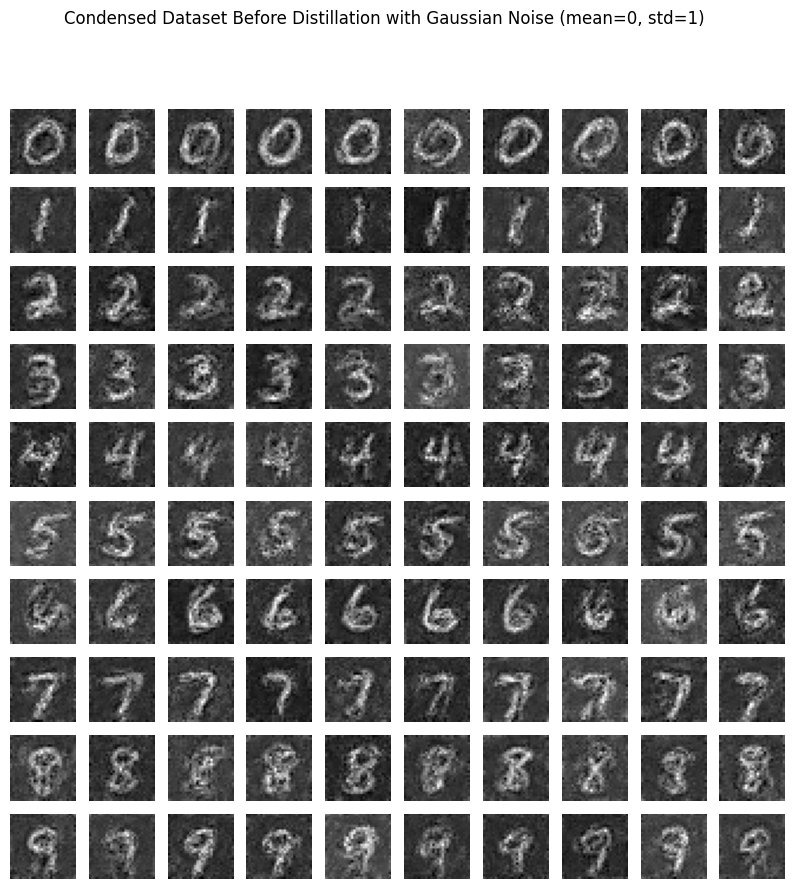

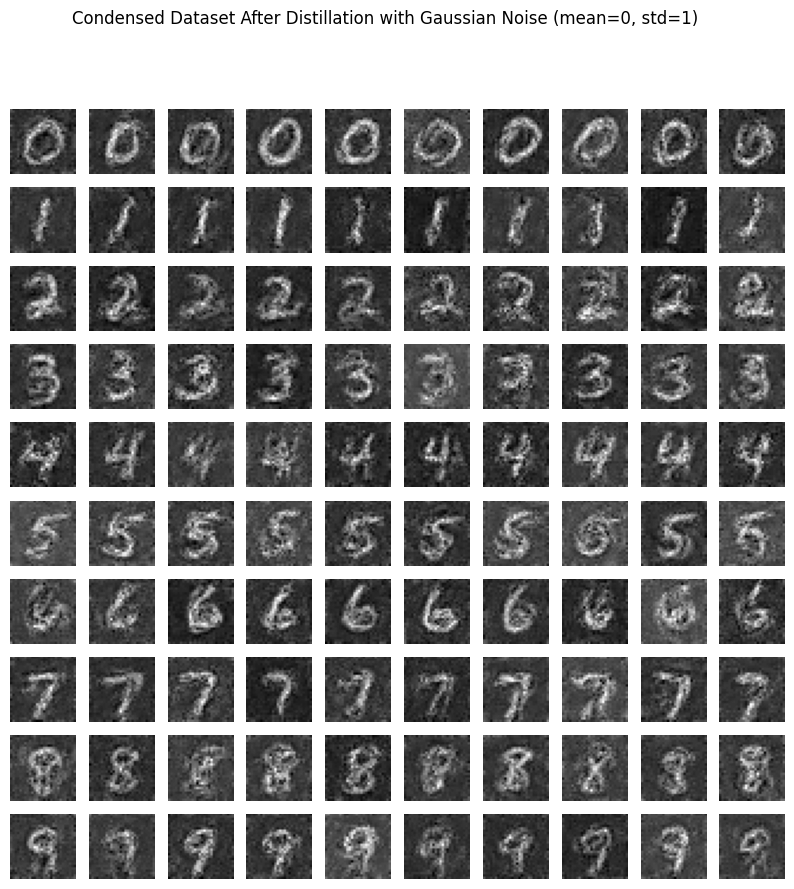

In [24]:
for j in [0,-1]:
    images = condensed_dataset[i][0]
    labels = condensed_dataset[i][1]

    fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))


    for i, ax in enumerate(axes.flat):
        img = images[i].numpy().squeeze()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    print("\n")
    if j == 0:
        fig.suptitle(f"Condensed Dataset Before Distillation with Gaussian Noise (mean={mean_gaussian}, std={std_gaussian})")
    else:
        fig.suptitle(f"Condensed Dataset After Distillation with Gaussian Noise (mean={mean_gaussian}, std={std_gaussian})")
    plt.show()

#Save the distilled dataset
torch.save(condensed_dataset[-1], os.path.join(data_path, 'synthetic_dataset_MNIST', 'MNIST_Distilled_Gaussian_Noise.pt'))



In [25]:
#define the model
net = 'ConvNetD3'

Distillator = DataDAM(net, dst_train, 10, num_classes=num_classes, im_size=im_size, channels=channel, 
                      save_path=os.path.join(data_path, 'synthetic_dataset_MNIST'),
                      batch_size=256, K=100, T=10, eta_S = 0.1, zeta_S = 1, eta_theta = 0.01, zeta_theta=50, lambda_mmd=0.01, device=device)

Distillator.initialize_synthetic_dataset_from_real()


trainloader = torch.utils.data.DataLoader(dst_train, batch_size=64, shuffle=True)
condensed_dataset = Distillator.run()

K:  37%|███▋      | 37/100 [01:03<01:48,  1.73s/it]


KeyboardInterrupt: 

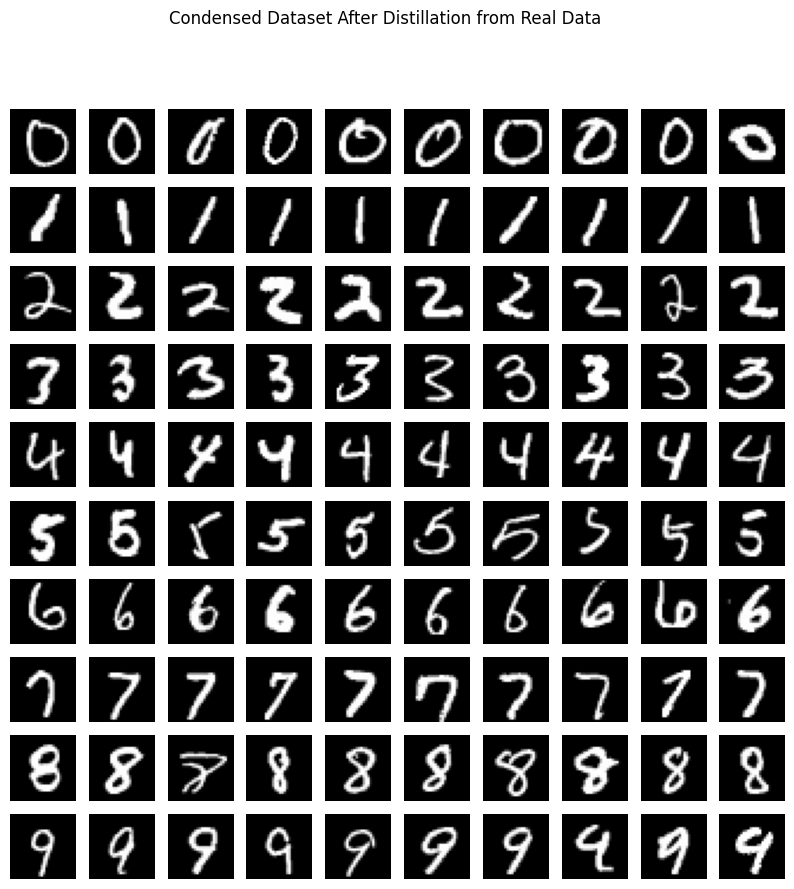

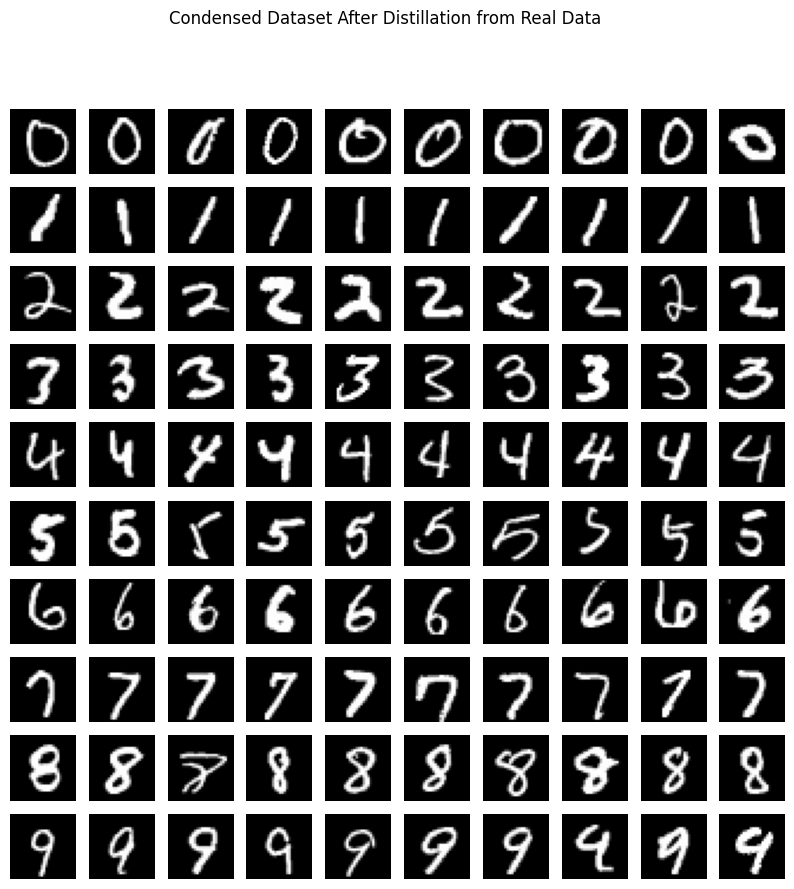

In [18]:
for j in [0,-1]:
    images = condensed_dataset[i][0]
    labels = condensed_dataset[i][1]

    fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))
    # fig.suptitle(iteration)

    for i, ax in enumerate(axes.flat):
        img = images[i].numpy().squeeze()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    print("\n")
    if j == 0:
        fig.suptitle(f"Condensed Dataset Before Distillation from Real Data")
    else:
        fig.suptitle(f"Condensed Dataset After Distillation from Real Data")
    plt.show()

#Save the distilled dataset
torch.save(condensed_dataset[-1], os.path.join(data_path, 'synthetic_dataset_MNIST', 'MNIST_Distilled_Real_Data.pt'))



In [20]:
from DataDAM import DataDAM
import os

#MNIST Dataset
data_save_path = "./Project A/data"
data_path = "mhist_dataset"


#create a folder to save the synthetic dataset
if not os.path.exists(os.path.join(data_save_path, 'synthetic_dataset_MHIST')):
    os.makedirs(os.path.join(data_save_path, 'synthetic_dataset_MHIST'))


#load the dataset
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset("MHIST", data_path)

#define the model
net = 'ConvNetD7'

Distillator = DataDAM(net, dst_train, 50, num_classes=num_classes, im_size=im_size, channels=channel, 
                      save_path=os.path.join(data_path, 'synthetic_dataset_MHIST'),
                      batch_size=128, K=200, T=10, eta_S = 0.1, zeta_S = 1, eta_theta = 0.01, zeta_theta=50, lambda_mmd=0.01, device=device)

mean_gaussian = 0
std_gaussian = 1
Distillator.initialize_synthetic_dataset_from_gaussian_noise(mean_gaussian,std_gaussian)


trainloader = torch.utils.data.DataLoader(dst_train, batch_size=64, shuffle=True)
condensed_dataset = Distillator.run()




K:  21%|██        | 21/100 [01:32<05:47,  4.40s/it]


KeyboardInterrupt: 

In [ ]:
for j in [0,-1]:
    images = condensed_dataset[i][0]
    labels = condensed_dataset[i][1]

    fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))


    for i, ax in enumerate(axes.flat):
        img = images[i].numpy().squeeze()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    print("\n")
    if j == 0:
        fig.suptitle(f"Condensed Dataset Before Distillation with Gaussian Noise (mean={mean_gaussian}, std={std_gaussian})")
    else:
        fig.suptitle(f"Condensed Dataset After Distillation with Gaussian Noise (mean={mean_gaussian}, std={std_gaussian})")
    plt.show()

#Save the distilled dataset
torch.save(condensed_dataset[-1], os.path.join(data_save_path, 'synthetic_dataset_MHIST', 'MHIST_Distilled_Gaussian_Noise.pt'))



In [ ]:
from DataDAM import DataDAM
import os

#MNIST Dataset
data_save_path = "./Project A/data"
data_path = "mhist_dataset"


#create a folder to save the synthetic dataset
if not os.path.exists(os.path.join(data_save_path, 'synthetic_dataset_MHIST')):
    os.makedirs(os.path.join(data_save_path, 'synthetic_dataset_MHIST'))


#load the dataset
channel, im_size, num_classes, class_names, mean, std, dst_train, dst_test, testloader = get_dataset("MHIST", data_path)

#define the model
net = 'ConvNetD7'

Distillator = DataDAM(net, dst_train, 50, num_classes=num_classes, im_size=im_size, channels=channel, 
                      save_path=os.path.join(data_path, 'synthetic_dataset_MHIST'),
                      batch_size=128, K=200, T=10, eta_S = 0.1, zeta_S = 1, eta_theta = 0.01, zeta_theta=50, lambda_mmd=0.01, device=device)

Distillator.initialize_synthetic_dataset_from_real()


trainloader = torch.utils.data.DataLoader(dst_train, batch_size=64, shuffle=True)
condensed_dataset = Distillator.run()




In [ ]:
for j in [0,-1]:
    images = condensed_dataset[i][0]
    labels = condensed_dataset[i][1]

    fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10))


    for i, ax in enumerate(axes.flat):
        img = images[i].numpy().squeeze()
        ax.imshow(img, cmap='gray')
        ax.axis('off')
    print("\n")
    if j == 0:
        fig.suptitle(f"Condensed Dataset Before Distillation from Real Data")
    else:
        fig.suptitle(f"Condensed Dataset After Distillation from Real Data")
    plt.show()

#Save the distilled dataset
torch.save(condensed_dataset[-1], os.path.join(data_save_path, 'synthetic_dataset_MHIST', 'MHIST_Distilled_Real_Data.pt'))

